In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
from scipy.optimize import least_squares
import networkx as nx

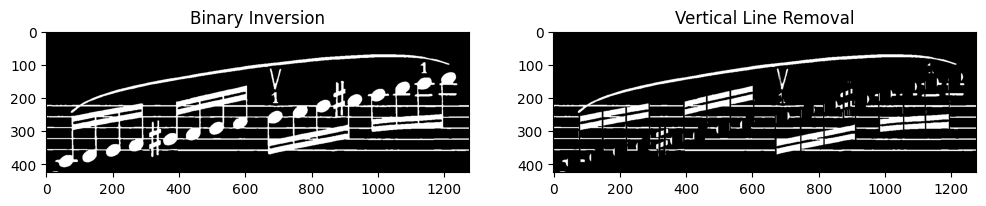

In [2]:
# Load the image in grayscale
image_path = "HN7_129_3.png"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Convert to binary using Otsu's thresholding
_, binary = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Remove Note Stems (Vertical Lines)
vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 25))
stems = cv2.morphologyEx(binary, cv2.MORPH_OPEN, vertical_kernel, iterations=1)
binary_no_stems = cv2.subtract(binary, stems)  # Remove detected stems

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(binary, cmap="gray")
axes[0].set_title("Binary Inversion")
axes[1].imshow(binary_no_stems, cmap="gray")
axes[1].set_title("Vertical Line Removal")
plt.show()

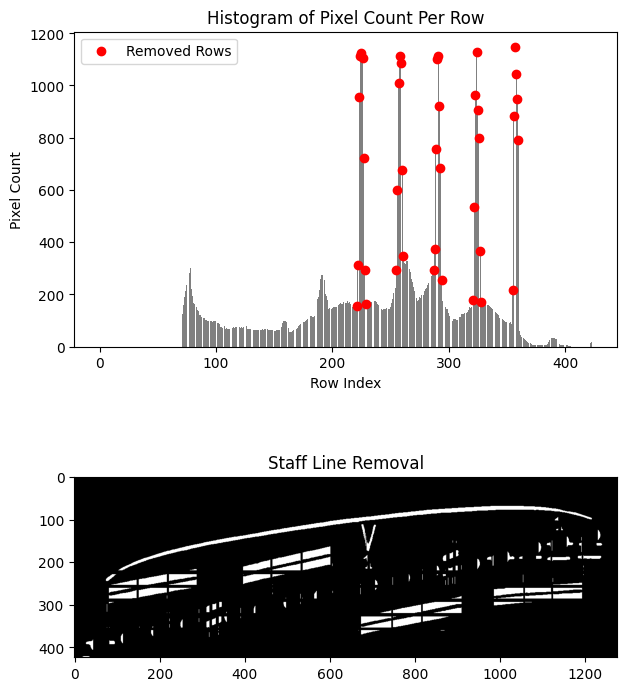

In [3]:
row_pixel_count = np.sum(binary_no_stems > 0, axis=1)  # Compute Row-Wise Histogram
max_pixel_count = np.max(row_pixel_count)  # The max pixel count (usually full image width)
rows_to_remove = set(np.where(row_pixel_count > 0.6 * max_pixel_count)[0])  # Primary detection

# Extend Removal to Neighboring Rows If Above Threshold
for row in list(rows_to_remove):
    for neighbor in [row - 2, row + 2]:
        if 0 <= neighbor < binary_no_stems.shape[0] and row_pixel_count[neighbor] > 0.1 * max_pixel_count:
            rows_to_remove.add(neighbor)  # Add neighboring row if above 10% threshold
rows_to_remove = sorted(rows_to_remove)

# Clear Detected Staff Lines
binary_cleaned = binary_no_stems.copy()
binary_cleaned[rows_to_remove, :] = 0  # Set selected rows to black

fig, axes = plt.subplots(2, 1, figsize=(7, 9))
axes[0].bar(range(len(row_pixel_count)), row_pixel_count, color="gray")
axes[0].scatter(rows_to_remove, row_pixel_count[rows_to_remove], color="red", label="Removed Rows", zorder=3)
axes[0].set_title("Histogram of Pixel Count Per Row")
axes[0].set_xlabel("Row Index")
axes[0].set_ylabel("Pixel Count")
axes[0].legend()
axes[1].imshow(binary_cleaned, cmap='gray')
axes[1].set_title("Staff Line Removal")
plt.show()

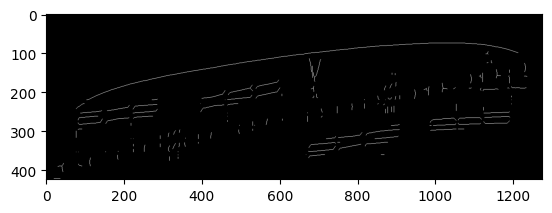

In [4]:
skeleton = skeletonize(binary_cleaned > 0)  # Apply skeletonization
# skeleton = cv2.ximgproc.thinning(binary_cleaned, thinningType=cv2.ximgproc.THINNING_ZHANGSUEN)
skeleton_cleaned = (skeleton * 255).astype(np.uint8)  # Convert back to uint8 format for visualization

plt.imshow(skeleton_cleaned, cmap="gray")
plt.show()

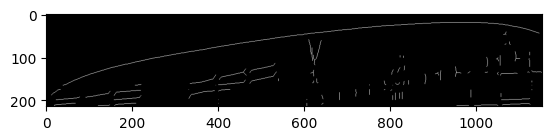

In [5]:
# Extract Slur Inside Bounding Box
# bbox = [65, 55, 756, 164]  # 128_6
# bbox = [65, 55, 452, 150]  # 128_17
# bbox = [65, 60, 183, 147]  # 128_24
# bbox = [65, 60, 566, 198]  # 129_1
# bbox = [65, 55, 648, 202]  # 129_2
bbox = [65, 55, 1220, 269]  # 129_3
# bbox = [65, 55, 828, 142]  # 66_8
# bbox = [65, 55, 1068, 164]  # 66_9
x_min, y_min, x_max, y_max = bbox
w, h = x_max - x_min, y_max - y_min

# Crop the cleaned skeletonized image
slur_crop = skeleton_cleaned[y_min:y_max, x_min:x_max]
plt.imshow(slur_crop, cmap="gray")
plt.show()

# Extract skeleton points inside the bounding box
y_coords, x_coords = np.where(slur_crop > 0)
points = np.column_stack((x_coords, y_coords))

72


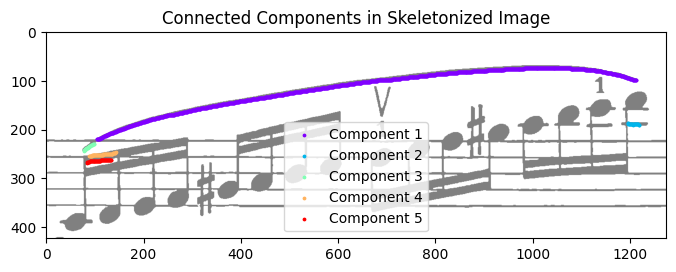

In [6]:
# Build Graph and Find Slur Segments
G = nx.Graph()
for i in range(len(points)):
    for j in range(i + 1, len(points)):
        if np.linalg.norm(points[i] - points[j]) < 3:  # Connect nearby pixels
            G.add_edge(tuple(points[i]), tuple(points[j]))

# Identify all disconnected components
connected_components = [np.array(sorted(c, key=lambda p: p[0])) for c in nx.connected_components(G)]
print(len(connected_components))
for i in range(len(connected_components)):  # Apply bounding box offsets
    connected_components[i][:, 0] += x_min  # Shift x-coordinates
    connected_components[i][:, 1] += y_min  # Shift y-coordinates

# Find the Longest Component (Initial Slur)
initial_longest = max(connected_components, key=len)
# Remove Components Within the X-range of the Slur
x_min_slur, x_max_slur = np.min(initial_longest[:, 0]), np.max(initial_longest[:, 0])
filtered_components = [
    c for c in connected_components if not (np.min(c[:, 0]) > x_min_slur and np.max(c[:, 0]) < x_max_slur)]

fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(image, cmap='gray', alpha=0.5)
ax.set_title("Connected Components in Skeletonized Image")
# Plot each connected component in different colors
colors = plt.cm.rainbow(np.linspace(0, 1, len(filtered_components)))
for i, component in enumerate(filtered_components):
    ax.scatter(component[:, 0], component[:, 1], color=colors[i], s=3, label=f"Component {i+1}")
plt.legend()
plt.show()

4


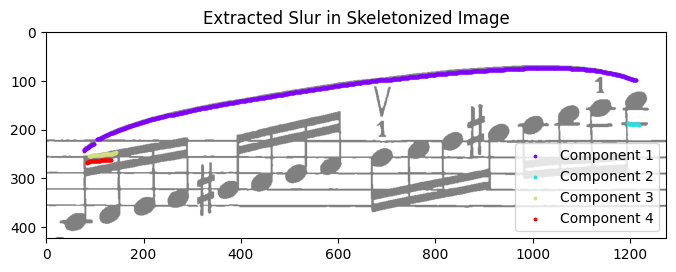

In [7]:
G_loose = nx.Graph()  # Reconnect nearby components with looser definition
for c in filtered_components:
    for i in range(len(c) - 1):  # Connect sequential points
        p1, p2 = tuple(c[i]), tuple(c[i + 1])
        G_loose.add_edge(p1, p2)

# Connect components if their closest points are within distance < 16
for i, comp1 in enumerate(filtered_components):
    for j, comp2 in enumerate(filtered_components):
        if i >= j:
            continue  # Avoid duplicate checks

        # Determine which component is on the left and right
        if np.min(comp1[:, 0]) < np.min(comp2[:, 0]):  
            left_component, right_component = comp1, comp2
        else:
            left_component, right_component = comp2, comp1

        rightmost_p1 = left_component[np.argmax(left_component[:, 0])]
        leftmost_p2 = right_component[np.argmin(right_component[:, 0])]
        min_distance = np.linalg.norm(rightmost_p1 - leftmost_p2)
        
        if min_distance < 16:
            G_loose.add_edge(tuple(rightmost_p1), tuple(leftmost_p2))  # Connect closest boundary points

# Find the New Longest Component (Final Slur)
final_components = [np.array(list(c)) for c in nx.connected_components(G_loose)]
print(len(final_components))

fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(image, cmap='gray', alpha=0.5)
ax.set_title("Extracted Slur in Skeletonized Image")
# Plot each connected component in different colors
colors = plt.cm.rainbow(np.linspace(0, 1, len(final_components)))
for i, component in enumerate(final_components):
    ax.scatter(component[:, 0], component[:, 1], color=colors[i], s=3, label=f"Component {i+1}")
plt.legend()
plt.show()

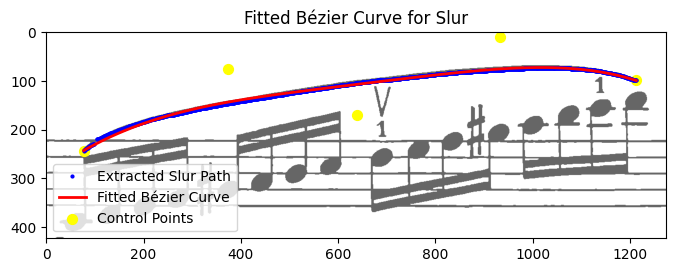

array([[  77.        ,  243.        ],
       [ 373.90259014,   74.8208164 ],
       [ 639.46012202,  169.17498369],
       [ 933.24386201,    9.60817293],
       [1213.        ,   99.        ]])

In [8]:
longest_component = max(final_components, key=len)  # In case there are multiple components
longest_component = longest_component[np.argsort(longest_component[:, 0])]
# Normalize Path for Bézier Fitting
longest_component = longest_component.astype(np.float32)
x_vals, y_vals = longest_component[:, 0], longest_component[:, 1]

# Initialize Bézier Control Points Based on Assumption
P0 = np.array([x_vals[0], y_vals[0]])  # Start point
P1 = np.array([np.mean(x_vals[:len(x_vals)//4]), np.min(y_vals)])  # First control point
P2 = np.array([np.mean(x_vals[len(x_vals)//4:len(x_vals)//2]), np.min(y_vals)])  # Second control point
P3 = np.array([np.mean(x_vals[len(x_vals)//2:3*len(x_vals)//4]), np.min(y_vals)])  # Third control point
P4 = np.array([x_vals[-1], y_vals[-1]])  # End point

# Define Bézier Curve Function (Degree 4)
def bezier_curve(t, P0, P1, P2, P3, P4):
    return (
        (1 - t) ** 4 * P0 +
        4 * (1 - t) ** 3 * t * P1 +
        6 * (1 - t) ** 2 * t ** 2 * P2 +
        4 * (1 - t) * t ** 3 * P3 +
        t ** 4 * P4
    )

def bezier_residuals(params, t_vals, target_points):
    """Compute residuals between target slur points and Bézier curve."""
    P1, P2, P3 = params.reshape(3, 2)  # Extract control points to optimize
    fitted_points = np.array([bezier_curve(t, P0, P1, P2, P3, P4) for t in t_vals])
    return (fitted_points - target_points).flatten()

# Normalize slur path for fitting
t_vals = np.linspace(0, 1, len(longest_component))
target_path = np.column_stack((x_vals, y_vals))

# Optimize control points using least squares fitting
initial_guess = np.hstack([P1, P2, P3])
res = least_squares(bezier_residuals, initial_guess, args=(t_vals, target_path))

# Extract optimized control points
P1_opt, P2_opt, P3_opt = res.x.reshape(3, 2)
bezier_points = np.array([P0, P1_opt, P2_opt, P3_opt, P4])

# Generate Fitted Bézier Curve for Visualization
t_vals_fit = np.linspace(0, 1, 100)
fitted_curve = np.array([bezier_curve(t, *bezier_points) for t in t_vals_fit])

# Overlay Fitted Curve on the Original Image
fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(image, cmap='gray', alpha=0.6)
ax.set_title("Fitted Bézier Curve for Slur")

# Plot the extracted slur path
ax.plot(x_vals, y_vals, 'bo', markersize=2, label="Extracted Slur Path")
# Plot the fitted Bézier curve
ax.plot(fitted_curve[:, 0], fitted_curve[:, 1], 'r-', linewidth=2, label="Fitted Bézier Curve")
# Plot control points
ax.scatter(bezier_points[:, 0], bezier_points[:, 1], color='yellow', label="Control Points", s=50)
plt.legend()
plt.show()

# Output final Bézier control points
bezier_points
